In [1]:
struct Models
    # parameters
    β::Float64 # discount factor
    γ::Float64 # relative risk aversion
    
    # factor price
    rent::Float64 # net interest rate
    
    # grid
    nw::Int64 # the number of income grid
    w_max::Float64 # the maximum value of income grid
    w_min::Float64 # the minimum value of income grid
    grid_w::Vector{Float64} # income grid
end

In [2]:
function Calibration()
    # set parameters here
    β = 0.985^30
    γ = 2.0
    rent = 1.025^30 - 1.0
    nw = 10
    w_max = 1.0
    w_min = 0.1

    grid_w = collect(LinRange(w_min, w_max, nw))

    return Models(β, γ, rent, nw, w_max, w_min, grid_w)
end

Calibration (generic function with 1 method)

In [3]:
function mu_CRRA(cons::Float64, γ::Float64)
    return cons^(-γ)
end

mu_CRRA (generic function with 1 method)

In [4]:
# Load the required packages
using Plots
# pyplot()
using Roots # This is new: It used to be Optim

# Using the first order condition: Root finding algortihm
<!-- # 一階条件を使う：求根アルゴリズム -->

# Finding zeros of nonlinear equation
<!-- ## 非線形方程式のゼロ点を探す -->

- After substituting the budget constraint, the first-order condition of the two-period model (3) becomes (the Euler equation)
<!-- - 予算制約を代入した後の2期間モデルの一階条件(3)は、 -->

$$
  u'(w-a) = (1+r)\beta u'((1+r)a) \tag{6}
$$

<!-- となる（オイラー方程式）。 -->

- As in the previous section, $w_{i}$ is discretized
<!-- - 前節と同様に、$w_{i}$については離散化して考えると、 -->

$$
  u'(w_{i}-a) = (1+r)\beta u'((1+r)a)
$$

The only unknown variable is $a$.
<!-- なので、未知の変数は$a$のみである。 -->

- By rewriting Eq. (6)
<!-- - (6)式を、 -->

$$
  R(w_{i}) = (1+r)\beta \frac{u'((1+r)a)}{u'(w_{i}-a)} -1 \tag{7}
$$

we can read it as a root-finding problem of the residual function to find $a$ such that $R(w_{i}) =0$ for a given $w_{i}$
<!-- と書き換えると、ある$w_{i}$のもとで$R(w_{i}) =0$となるような$a$、すなわち残差関数(residual function)のゼロ点を探す問題(root-finding problem：求根問題)に読み替えることができる。 -->

- A possibility that the residual function has a complex form of nonlinear equation
<!-- - 残差関数は複雑の形をした非線形方程式の可能性 -->

- The study about methods to find zeros of nonlinear equation has a long tradition and there are various approaches
<!-- - 非線形方程式のゼロ点を探す手法に関する研究は長い歴史を持つため、既に様々なアプローチが存在 -->
    - For MATLAB, fzero
    - For Python, fsolve in Scipy
    - For Julia, functions in Optim.jl
<!--     - MATLABであれば、fzero -->
<!--     - Pythonであれば、SciPyにある関数fsolve -->
<!--     - Juliaであれば、Optim.jlにある関数 -->

- Algorithm
<!-- - アルゴリズム -->

1. Set parameters (calibration)

2. Let $w_{i}\in\{w_{1},\dots,w_{I}\}$ be the discretized income in the young period

3. Find $a$ such that makes (8) zero for each $w_{i}$ using root-finding algorithm in each language

4. The obtained combination of $w_{i}$ and $a$ is the saving function

<!-- 1. パラメータを設定する（カリブレーション）。

2. $w_{i}\in\{w_{1},\dots,w_{I}\}$を離散化した若年期の所得とする。

3. 各$w_{i}$について、(8)式がゼロになる$a$を探し出す。ゼロ点を探すためには、各言語に備わっている（あるいは外部ライブラリの）求根アルゴリズムを利用する。

4. 得られた各$w_{i}$と$a$の組み合わせが貯蓄関数である。 -->

In [5]:
function resid_two_period(a::Float64, w_val::Float64, params::Models)

    # The right-hand side of the Euler equation: The marginal utility when young
    if w_val - a > 0.0
        mu1 = mu_CRRA(w_val - a, params.γ)
    else
        mu1 = 10000.0
    end

    # The marginal utility when old
    mu2 = mu_CRRA((1.0 + params.rent)*a, params.γ)

    # Residual
    return params.β*(1.0 + params.rent)*(mu2/mu1) - 1.0

end 

resid_two_period (generic function with 1 method)

In [9]:
# Set parameters
#params = Calibration()
# set parameters here
β = 0.985^30
γ = 2.0
rent = 1.025^30 - 1.0
nw = 10
w_max = 1.0
w_min = 0.1

grid_w = collect(LinRange(w_min, w_max, nw))

# return Models(β, γ, rent, nw, w_max, w_min, grid_w)
params = Models(β, γ, rent, nw, w_max, w_min, grid_w)

# Prepare empty variables
a_nl = zeros(params.nw)

# Find a such that the residual function becomes zero for each w_{i}
for i = 1:params.nw

    w_val = params.grid_w[i]

    # Make a function which has a as the only argument
    resid_two_period!(a) = resid_two_period(a, w_val, params)

    # 0.01 is an initial value to find the zero
    a_nl[i] = find_zero(resid_two_period!, 0.01)

end

print(a_nl)

[0.03550088777115455, 0.0710017755423091, 0.10650266331346363, 0.1420035510846182, 0.17750443885577274, 0.21300532662692728, 0.2485062143980818, 0.2840071021692364, 0.3195079899403909, 0.3550088777115455]

In [7]:
# Analytical solution: Eq. (2.4)
coef1 = (params.β*(1.0+params.rent))^(-1.0/params.γ)
coef2 = 1.0/(1.0+coef1*(1.0+params.rent))
a_cfs = coef2*params.grid_w;

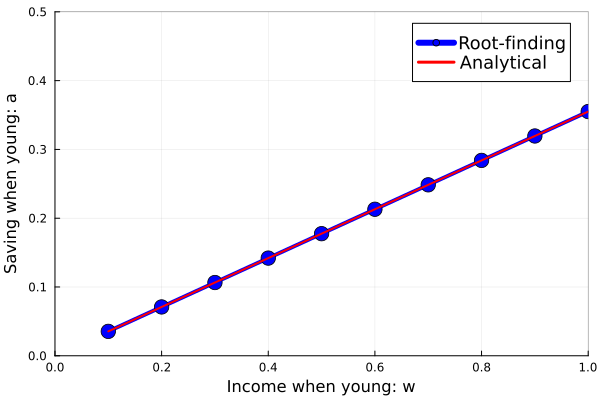

In [8]:
# Almost the same as Figure 2.2
plt = plot(params.grid_w, a_nl,
    color = :blue,
    marker = :circle,
    legend = :topright,
    xlims = (0, 1.0),
    ylims = (0, 0.5),
    label = ("Root-finding"),
    xlabel = ("Income when young: w"),
    ylabel = ("Saving when young: a"),
    linewidth = 4,
    markersize = 8,
#     titlefont = font("HackGen35Nerd", 12),
#     guidefont = font("HackGen35Nerd", 12),
#     tickfont = font("HackGen35Nerd", 8),
#     legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(params.grid_w, a_cfs, linewidth = 2, color = :red, label="Analytical")
#savefig("Fig2_pol_root_finding.pdf")